#### CSC 180 Intelligent Systems 

#### William Lorence, Ajaydeep Singh, Romin Akoliya, Abdurraziq Paikur

#### California State University, Sacramento

# Final Project: NBA Outcome Predictions

NBA statistics can be very complex, so first, we will break down exactly what we are looking for.



## Initial Data Gathering

#### First, we pull the data from the NBA stats website using the NBA API. The desired outcome is to have datasets for each of the 30 NBA teams from the 2021 season onward.

SEASON_ID is modified to contain the year instead of the season ID; the two are closely linked and only a simple mutation is necessary. (22024 -> 2024)
WL is modified to become a boolean instead of containing W and L.
MATCHUP is modified to drop the team in question and only leave the opponent, as it contained redundant information. (BOS vs. LAL -> LAL)

#### Some data is removed from the table. Here is a list and reasons:

TEAM_ID, GAME_ID: Numbers only useful within the NBA API workflow, not for statistics
GAME_DATE: The date a game takes place is not very impactful in determining who wins
TEAM_NAME: Redundant, only need three letter team abbreviation
MIN: Length of the game, not relevant as most games (sparing overtime) are around the same length
PLUS_MINUS: Point differential between the team in question and the opponent; can provide redundant information as teams with a positive plus-minus are guaranteed to have won the game

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nba_api.stats.endpoints import leaguegamefinder

# Find all NBA regular season games from 2021 onward (NBA id = 00)

gamefinder = leaguegamefinder.LeagueGameFinder(league_id_nullable='00', season_type_nullable='Regular Season')
games = gamefinder.get_data_frames()[0]  # Fetch the data as a DataFrame

games.rename(columns={'SEASON_ID': 'SEASON'}, inplace=True)
games['SEASON'] = games['SEASON'].str[1:5].astype(int)
games = games[games['SEASON'] >= 2019]

# Create a simple win/loss indicator
games['WL'] = games['WL'] == 'W'
games = games.replace({True: 1, False: 0})
games.rename(columns={'WL': 'WIN'}, inplace=True)

# Add LAST_GAME_RESULT feature
games['LAST_GAME_RESULT'] = games.groupby('TEAM_ID')['WIN'].shift(-1).fillna(0)

# Add HOME_GAME feature
games['HOME_GAME'] = games['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Change "matchup" to "opponent" and "team_abbreviation" to "team"
games['MATCHUP'] = games['MATCHUP'].str[-3:]
games.rename(columns={'MATCHUP': 'OPPONENT'}, inplace=True)
games.rename(columns={'TEAM_ABBREVIATION': 'TEAM'}, inplace=True)

# Drop unnecessary columns
games = games.drop(['TEAM_ID', 'GAME_ID', 'GAME_DATE', 'TEAM_NAME', 'MIN', 'PLUS_MINUS'], axis=1)

C:\Users\legow\AppData\Local\Temp\ipykernel_20120\4218288369.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  games = games.replace({True: 1, False: 0})


#### The following function simply normalizes the various game statistics on a league-wide scale. This is important, because it will show which teams average higher numbers.

In [6]:
def normalize_columns(df, columns = []):
    for col in columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

games = normalize_columns(games, ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'])

games

,SEASON,TEAM,OPPONENT,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,LAST_GAME_RESULT,HOME_GAME
0,2024,BKN,SAC,1,-0.377049,-1.029109,-1.924830,0.210237,1.660119,0.613893,...,-1.138973,-1.612986,-1.973424,-0.242859,-0.189867,0.052720,-0.340941,0.797336,0.0,0
1,2024,DAL,MIA,0,0.419559,0.502829,2.348717,-0.897950,-0.655001,0.759342,...,1.249511,1.873456,2.250384,0.747374,-0.536422,1.664219,-0.082160,1.035905,1.0,0
2,2024,MIN,BOS,0,-0.616032,-0.837617,-0.072960,-0.879783,0.631177,0.904791,...,0.187963,0.772474,0.741881,-1.233091,-1.922642,-1.558778,-1.376068,-0.395509,0.0,0
3,2024,CLE,TOR,1,0.738203,1.268797,1.209104,0.482742,0.888413,0.904791,...,0.984124,0.221983,0.741881,0.351281,1.196353,-0.350154,-0.082160,0.320198,1.0,1
4,2024,IND,WAS,1,0.180577,-0.071648,-0.357863,0.155736,-0.140530,-1.131494,...,0.453350,-0.145011,0.138480,1.143466,0.156688,-0.753029,-0.599723,-0.395509,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12153,2019,IND,DET,0,-0.217727,-0.071648,0.069492,-0.134936,-1.169472,-2.004187,...,-0.077425,-1.429489,-1.219173,0.153234,0.156688,0.455595,0.435404,1.990181,0.0,1
12154,2019,NOP,TOR,0,0.738203,0.311336,1.921362,-0.843449,1.660119,1.486586,...,1.514899,0.588977,1.345282,0.945420,-1.229532,1.664219,1.470531,3.421595,0.0,0
12155,2019,LAL,LAC,0,-0.855014,-0.837617,-0.500315,-0.607278,0.116706,-0.258800,...,-0.342812,-0.328508,-0.464921,-1.035044,-1.229532,0.858470,0.176622,1.035905,0.0,0
12156,2019,TOR,NOP,1,1.375489,0.119844,2.063814,-1.097787,0.373941,0.759342,...,1.514899,1.322965,1.948683,-0.440905,-0.189867,-0.753029,0.694186,1.035905,0.0,1


#### After normalization, we can finally split the data into the respective team files.

In [7]:
def create_team_csv_files(df, column = 'TEAM'):
    for team in df[column].unique():
        team_df = df.loc[df[column] == team]
        team_df.to_csv('datasets/' + team + '.csv', index=False)

create_team_csv_files(games)

#### With our csv files now created to refer to, we can read from them and feed the appropriate data to the model. However, some manipulation needs to be done first that would cause the size of the CSV files to be unnecessarily large.

In [8]:
team1 = "LAL"
df_team1 = pd.read_csv('datasets/' + team1 + '.csv')

df_team1

,SEASON,TEAM,OPPONENT,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,LAST_GAME_RESULT,HOME_GAME
0,2024,LAL,DEN,0,-0.855014,-0.454633,-0.072960,-0.461942,0.116706,0.177546,...,-1.138973,-1.429489,-1.822574,0.351281,1.196353,-0.753029,0.435404,-0.872647,0.0,1
1,2024,LAL,ORL,0,0.419559,0.502829,-0.215411,0.682579,0.116706,-0.549698,...,-0.342812,-1.245992,-1.219173,-0.836998,-1.229532,0.455595,-0.858505,-1.111216,1.0,1
2,2024,LAL,UTA,1,0.897524,0.119844,-1.782379,1.536429,0.373941,-0.549698,...,-1.138973,-1.062495,-1.520873,0.945420,0.503243,0.052720,0.176622,-0.872647,1.0,1
3,2024,LAL,NOP,1,-0.695692,-0.454633,0.069492,-0.552777,-0.140530,0.759342,...,1.780286,-1.429489,-0.163221,-0.242859,0.849798,-0.753029,-0.599723,-1.349785,1.0,0
4,2024,LAL,SAS,1,0.578881,0.502829,-0.072960,0.573577,0.373941,-0.549698,...,-0.077425,-0.512004,-0.464921,0.351281,0.849798,-0.753029,-0.858505,-2.065492,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2019,LAL,DAL,1,0.499220,1.077305,1.066653,0.391907,-0.912236,-0.404249,...,-1.138973,0.221983,-0.464921,-0.242859,1.196353,0.858470,-0.599723,0.320198,1.0,0
401,2019,LAL,MEM,1,0.578881,-0.263140,-0.357863,-0.062268,-1.426707,-1.276943,...,-0.077425,1.873456,1.496133,-0.044812,0.503243,1.261344,1.211749,-0.156940,1.0,1
402,2019,LAL,CHA,1,0.578881,1.460290,0.639298,1.064086,-0.397765,-0.549698,...,-0.077425,0.588977,0.440181,0.945420,-0.189867,1.261344,-0.082160,0.558767,1.0,1
403,2019,LAL,UTA,1,-1.412640,-1.412094,-0.357863,-1.333959,-1.169472,-1.276943,...,0.187963,-0.512004,-0.314071,-1.233091,2.236018,1.664219,0.176622,0.320198,0.0,1


#### First, we one-hot encode the opponent column, as it is the only qualitative column we will be keeping. Then, we will remove the season and team columns because they are redundant, and only helped identify that the data is coming from the correct place.

In [9]:
df_team1 = pd.get_dummies(df_team1, columns=['OPPONENT'])
df_team1['OPPONENT_' + df_team1['TEAM']] = 0

df_team1 = df_team1.drop(['SEASON','TEAM'],axis=1)
df_team1

,WIN,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,...,OPPONENT_ORL,OPPONENT_PHI,OPPONENT_PHX,OPPONENT_POR,OPPONENT_SAC,OPPONENT_SAS,OPPONENT_TOR,OPPONENT_UTA,OPPONENT_WAS,OPPONENT_LAL
0,0,-0.855014,-0.454633,-0.072960,-0.461942,0.116706,0.177546,0.012928,-1.093624,-1.190981,...,False,False,False,False,False,False,False,False,False,0
1,0,0.419559,0.502829,-0.215411,0.682579,0.116706,-0.549698,0.702078,-0.074492,0.509208,...,True,False,False,False,False,False,False,False,False,0
2,1,0.897524,0.119844,-1.782379,1.536429,0.373941,-0.549698,1.094181,1.454208,1.926032,...,False,False,False,False,False,False,False,True,False,0
3,1,-0.695692,-0.454633,0.069492,-0.552777,-0.140530,0.759342,-0.711869,-0.584058,-0.624251,...,False,False,False,False,False,False,False,False,False,0
4,1,0.578881,0.502829,-0.072960,0.573577,0.373941,-0.549698,1.094181,0.095364,0.084161,...,False,False,False,False,False,True,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1,0.499220,1.077305,1.066653,0.391907,-0.912236,-0.404249,-0.937625,-0.244347,-0.199204,...,False,False,False,False,False,False,False,False,False,0
401,1,0.578881,-0.263140,-0.357863,-0.062268,-1.426707,-1.276943,-1.080208,2.643196,2.351080,...,False,False,False,False,False,False,False,False,False,0
402,1,0.578881,1.460290,0.639298,1.064086,-0.397765,-0.549698,-0.058364,-1.093624,-1.190981,...,False,False,False,False,False,False,False,False,False,0
403,1,-1.412640,-1.412094,-0.357863,-1.333959,-1.169472,-1.276943,-0.616814,0.265219,0.225843,...,False,False,False,False,False,False,False,True,False,0


#### Finally, we can split the data into X and y, where y is the WIN column and X is the remainder of the data. The data is then split into training and test data.

In [10]:
from sklearn.model_selection import train_test_split

# Select features and target
X = df_team1.drop('WIN', axis=1)  # Use more features if available
y = df_team1['WIN']  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shape of training and test sets
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

Training features shape: (283, 50)
Test features shape: (122, 50)


## Creating a Simple Model for Testing

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(32, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

def train_model(model, X_train, y_train):
    # EarlyStopping to monitor validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,  # 20% of training data for validation
        epochs=50,             # Maximum number of epochs
        batch_size=32,         # Number of samples per gradient update
        callbacks=[early_stopping],
        verbose=1              # Display training progress
)
    
train_model(model, X_train, y_train)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5106 - loss: 0.6984 - val_accuracy: 0.6842 - val_loss: 0.6408
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7267 - loss: 0.6146 - val_accuracy: 0.7368 - val_loss: 0.6139
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8233 - loss: 0.5465 - val_accuracy: 0.7193 - val_loss: 0.5860
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8094 - loss: 0.5071 - val_accuracy: 0.7544 - val_loss: 0.5603
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 0.4919 - val_accuracy: 0.7719 - val_loss: 0.5360
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8070 - loss: 0.4485 - val_accuracy: 0.8070 - val_loss: 0.5145
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - loss: 0.4160 - val_accuracy: 0.8070 - val_loss: 0.4974
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.4087 - val_accuracy: 0.7895 - val_loss: 0.4840
Epoch 9

### Evaluating the Model

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, x_test, y_test):
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Convert probabilities to binary predictions if your model outputs probabilities
    y_pred_classes = (y_pred > 0.5).astype(int)  # Use the appropriate threshold

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Print the confusion matrix
    print("Confusion Matrix:\n", cm)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    accuracy = accuracy_score(y_test, y_pred_classes)

    # Print the results
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Get the probability predictions
    y_pred_prob = model.predict(x_test)

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Compute AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Confusion Matrix:
 [[37 15]
 [13 57]]
Accuracy: 0.7704918032786885
Precision: 0.7916666666666666
Recall: 0.8142857142857143
F1-Score: 0.8028169014084507


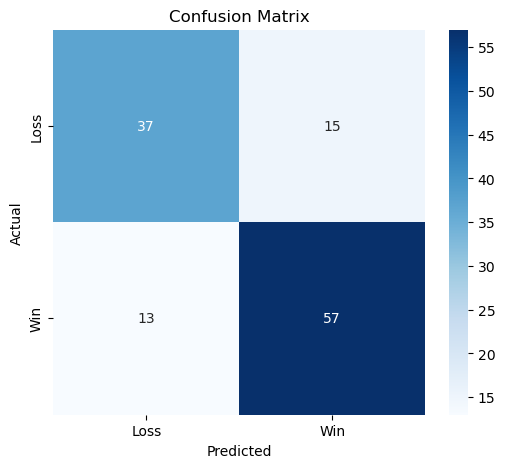

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


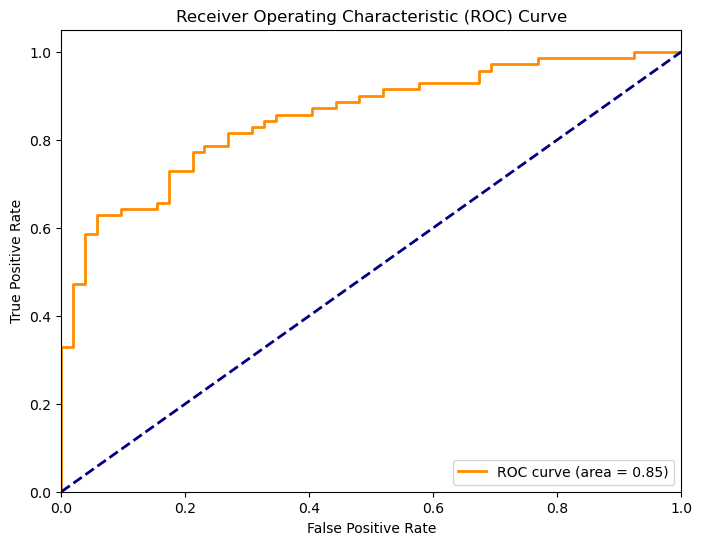

In [14]:
evaluate_model(model, X_test, y_test)

#### As we can see, the model is fairly accurate based on this data. However, we would also like to accomplish a few more things:

Test different kinds of models and model complexities

See raw probabilities (instead of rounding between 0 and 1) for betting odds - this is easy to do, as the model already outputs probabilities

Other possibilites, such as predicting season record (sum of predicted wins and losses for future schedule)




## Testing other Models

#### We will first be testing other types of models to see which is more accurate moving forward.

### More complex FCNN Model

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,273 (212.00 KB)

 Trainable params: 54,273 (212.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5728 - loss: 0.6467 - val_accuracy: 0.8070 - val_loss: 0.4676
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.3939 - val_accuracy: 0.8246 - val_loss: 0.4396
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8309 - loss: 0.3589 - val_accuracy: 0.8596 - val_loss: 0.3973
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8624 - loss: 0.3096 - val_accuracy: 0.8772 - val_loss: 0.3565
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8685 - loss: 0.2997 - val_accuracy: 0.8772 - val_loss: 0.3263
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8832 - loss: 0.2451 - val_accuracy: 0.8947 - val_loss: 0.3061
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8928 - loss: 0.2481 - val_accuracy: 0.8947 - val_loss: 0.2992
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8964 - loss: 0.2352 - val_accuracy: 0.8947 - val_loss: 0.2991
Epoch 9

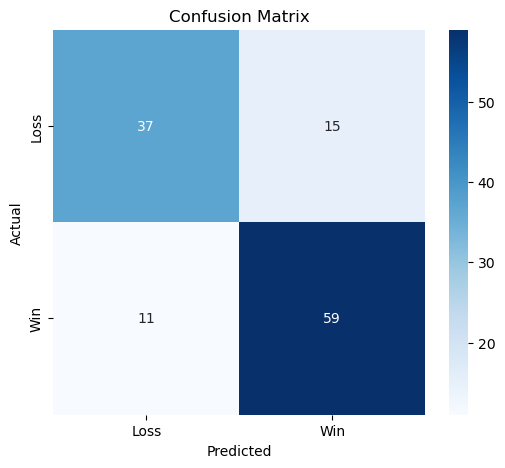

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


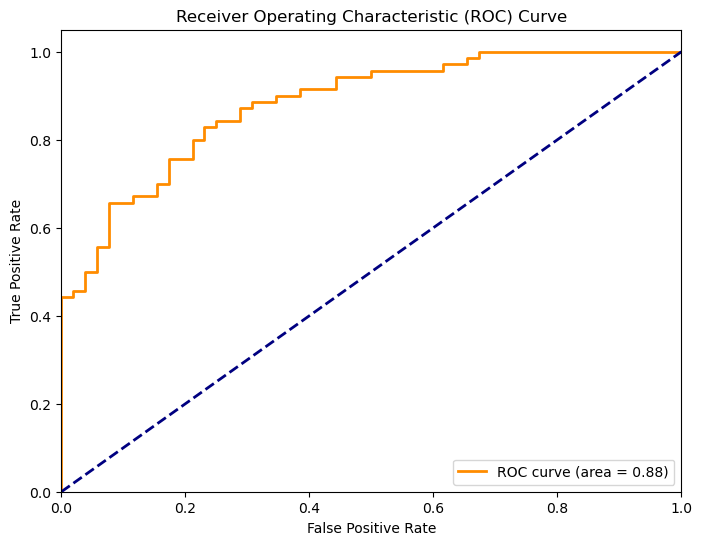

In [15]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
fcnn_model = Sequential([
    Dense(256, activation='tanh', input_shape=(X_train.shape[1],)),  # Input layer
    Dense(128, activation='tanh'),  # Hidden layer
    Dense(64, activation='tanh'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
fcnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
fcnn_model.summary()

#Train the model
train_model(fcnn_model, X_train, y_train)

#Evaluate the model
evaluate_model(fcnn_model, X_test, y_test)

### CNN Model

c:\Users\legow\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 44, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       360,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,241 (1.56 MB)

 Trainable params: 410,241 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6343 - loss: 0.5941 - val_accuracy: 0.7895 - val_loss: 0.4685
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8325 - loss: 0.3880 - val_accuracy: 0.7895 - val_loss: 0.4583
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8194 - loss: 0.4225 - val_accuracy: 0.7719 - val_loss: 0.4474
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8723 - loss: 0.3143 - val_accuracy: 0.8246 - val_loss: 0.4153
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8330 - loss: 0.3377 - val_accuracy: 0.7544 - val_loss: 0.5242
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8775 - loss: 0.3127 - val_accuracy: 0.8421 - val_loss: 0.4653
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8793 - loss: 0.2885 - val_accuracy: 0.8070 - val_loss: 0.4614
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8653 - loss: 0.2761 - val_accuracy: 0.8246 - val_loss: 0.5050
Epoch 9

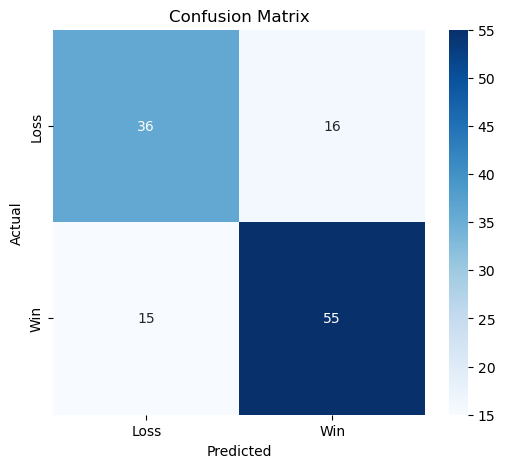

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


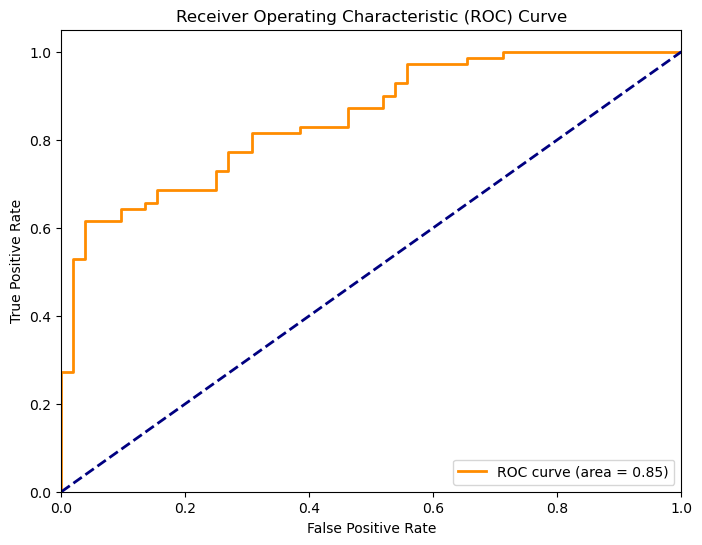

In [16]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten

def create_cnn(input_shape=(X_train.shape[1], 1), activation='tanh', neuron_count_array=[64,32], kernel_size_array=[3,3]):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=kernel_size_array[0], activation=activation, input_shape=(input_shape)))
    for i in range(len(kernel_size_array)-1):
        model.add(Conv1D(filters=128, kernel_size=kernel_size_array[i+1], activation=activation))
        model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    for j in range(len(neuron_count_array)-1):
        model.add(Dense(neuron_count_array[j], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Create CNN Model
cnn_model = create_cnn((X_train.shape[1], 1), activation='tanh', neuron_count_array=[128,64,32], kernel_size_array=[3,5])

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()

# Train the model
train_model(cnn_model, X_train, y_train)

# Evaluate the model
evaluate_model(cnn_model, X_test, y_test)

### Transfer Learning: RandomForestClassifier

Confusion Matrix:
 [[37 15]
 [18 52]]
Accuracy: 0.7295081967213115
Precision: 0.7761194029850746
Recall: 0.7428571428571429
F1-Score: 0.7591240875912408


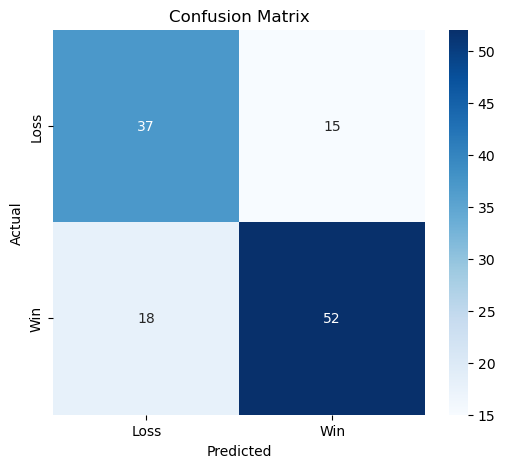

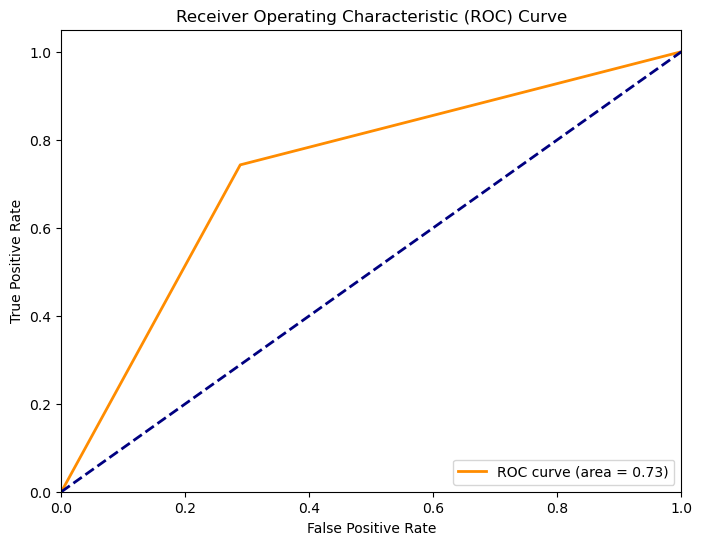

In [17]:
from sklearn.ensemble import RandomForestClassifier

transfer_model = RandomForestClassifier(n_estimators=100, random_state=42)
transfer_model.fit(X_train, y_train)

evaluate_model(transfer_model, X_test, y_test)

## Further Predictions

#### Using feature importance and some more data manipulation, we can use these models to predict direct matchups between two teams.

### Feature Importance

Feature importance allows us to see what parts of the data the model interprets as most useful. We can use this to isolate the most important data.

In [18]:
feature_importances = pd.DataFrame(transfer_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
# Each feature will be ranked based on its influence 
print("Feature Importances:\n", feature_importances)

Feature Importances:
                   importance
PTS                 0.110617
FG_PCT              0.093074
DREB                0.081877
REB                 0.073660
FGM                 0.064372
STL                 0.059812
FT_PCT              0.054558
AST                 0.041980
FTM                 0.041436
FG3_PCT             0.040616
BLK                 0.039842
FTA                 0.036041
TOV                 0.033259
FG3A                0.032943
OREB                0.032015
FGA                 0.031852
FG3M                0.026924
PF                  0.026857
OPPONENT_SAC        0.010334
HOME_GAME           0.006992
LAST_GAME_RESULT    0.006361
OPPONENT_LAC        0.003759
OPPONENT_SAS        0.003712
OPPONENT_DAL        0.003458
OPPONENT_OKC        0.003228
OPPONENT_CHA        0.003081
OPPONENT_MEM        0.003027
OPPONENT_GSW        0.003003
OPPONENT_BOS        0.002657
OPPONENT_POR        0.002454
OPPONENT_CLE        0.002260
OPPONENT_BKN        0.002136
OPPONENT_UTA        0

As expected, in-game stats play a bigger role than the opponent being played, as in general the team with higher overall stats will win the game.



Our next step in predicting outcomes involves finding the average numbers that a team puts up against a specific opponent. We will then use a previous model trained on the same data format to predict the outcome if these two teams played each other. The external conditions are isTeam1Home and didTeam1WinPrev, which simulate the status of team 1's last game and if they are playing the opponent in their home stadium.

In [27]:
team1 = 'CHA'
team2 = 'MIL'
isTeam1Home = 0
didTeam1WinPrev = 0

# Read the data from the files
df_team1 = pd.read_csv('datasets/' + team1 + '.csv')

# Isolate games where the team played the other team
df_team1_v_team2 = df_team1[df_team1['OPPONENT'] == team2]

# Get the averages for team1 vs. team2
def get_means(df, columns = []):
    df2 = pd.DataFrame(columns = columns)
    for col in columns:
        df2[col] = [df[col].mean()]
    return df2

df_team1_avg = get_means(df_team1_v_team2, ['PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF'])

# Add the other columns back (opponent, home game, last game result)
df_team1_avg['LAST_GAME_RESULT'] = didTeam1WinPrev
df_team1_avg['HOME_GAME'] = isTeam1Home

# Get opponent dummy columns
def addOppDummies(df, df2):
    df2 = pd.get_dummies(df2, columns=['OPPONENT'])
    opponent_cols = [col for col in df2.columns if 'OPPONENT' in col]
    for col in opponent_cols:
        df[col] = (col == 'OPPONENT_' + team2)
    df['OPPONENT_' + team1] = 0
    return df

df_team1_avg = addOppDummies(df_team1_avg, df_team1)

df_team1_avg

,PTS,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,...,OPPONENT_ORL,OPPONENT_PHI,OPPONENT_PHX,OPPONENT_POR,OPPONENT_SAC,OPPONENT_SAS,OPPONENT_TOR,OPPONENT_UTA,OPPONENT_WAS,OPPONENT_CHA
0,-0.431554,-0.555418,0.504344,-0.921854,0.279171,0.789963,-0.372296,-0.11919,-0.191747,0.23623,...,False,False,False,False,False,False,False,False,False,0


With this new data created, we can finally predict the outcomes of future games. Below is an example with the FCNN model from earlier:

In [28]:
prediction = fcnn_model.predict(df_team1_avg)[0][0]

print("Prediction: ", prediction) # Outputs 1 if our team wins

# Convert probabilities to percentages
percentage = prediction * 100

print(f'[{team1} wins - {percentage}%], [{team2} wins - {100-percentage}%]')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Prediction:  0.027026128
[CHA wins - 2.702612802386284%], [MIL wins - 97.29738719761372%]


With more time and work, this could be expanded even more to include different stats, options, etc, but we ran out of time to do anything more extensive. In the future it may be interesting to try to implement players into the equation, possibly predicting the odds of players hitting certain statlines against specific opponents (which is also a popular form of sports betting). Overall, we are pleased with the state of the project as it stands.